In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
 import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import sobel
from skimage.filters import scharr

In [6]:
data_dir = 'D:/archive/BananaLSD/AugmentedSet'
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

Found 1280 images belonging to 4 classes.
Found 320 images belonging to 4 classes.


In [9]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [11]:
class_weights

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

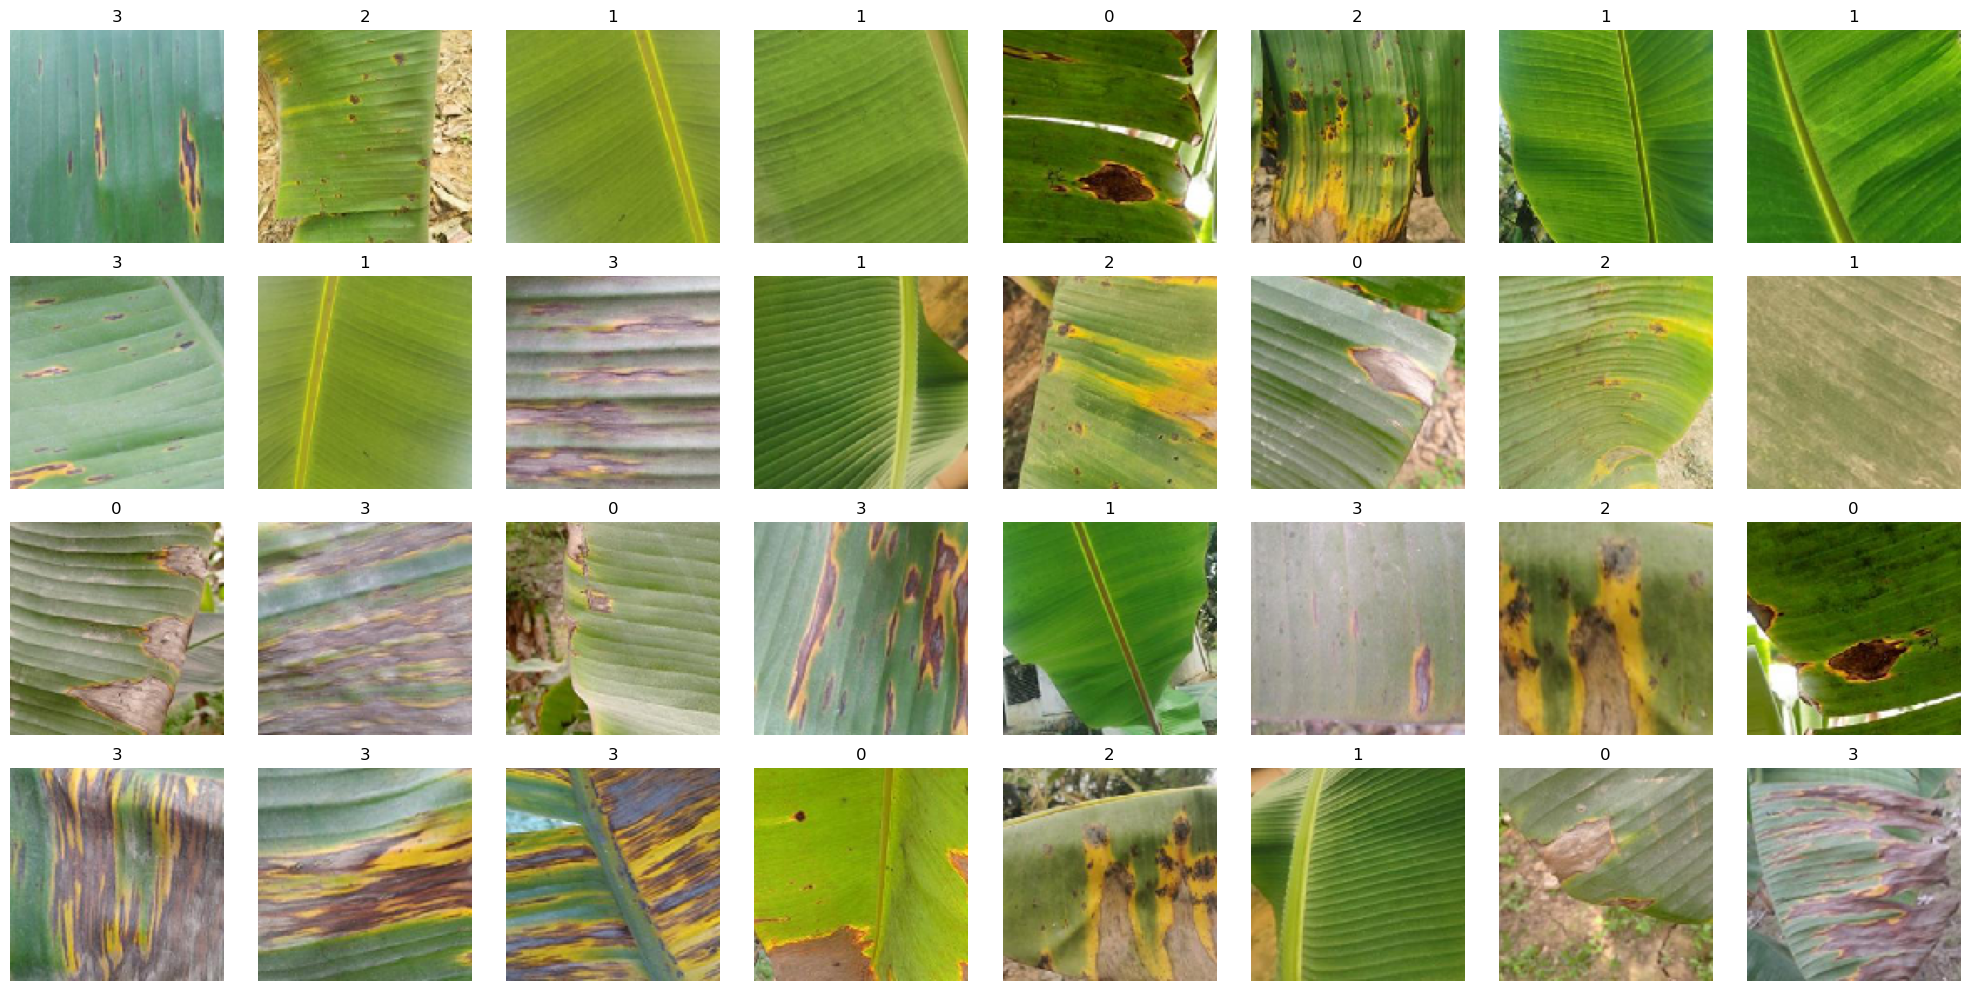

In [13]:
images, labels = next(train_generator)

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_images(images, labels)

In [14]:
def apply_sobel(images_arr):
    sobel_images = []
    for img in images_arr:
        gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        sobel_x = sobel(gray_img, axis=0, mode='constant')
        sobel_y = sobel(gray_img, axis=1, mode='constant')
        sobel_img = np.hypot(sobel_x, sobel_y)
        sobel_images.append(sobel_img)
    return np.array(sobel_images)

sobel_images = apply_sobel(images)

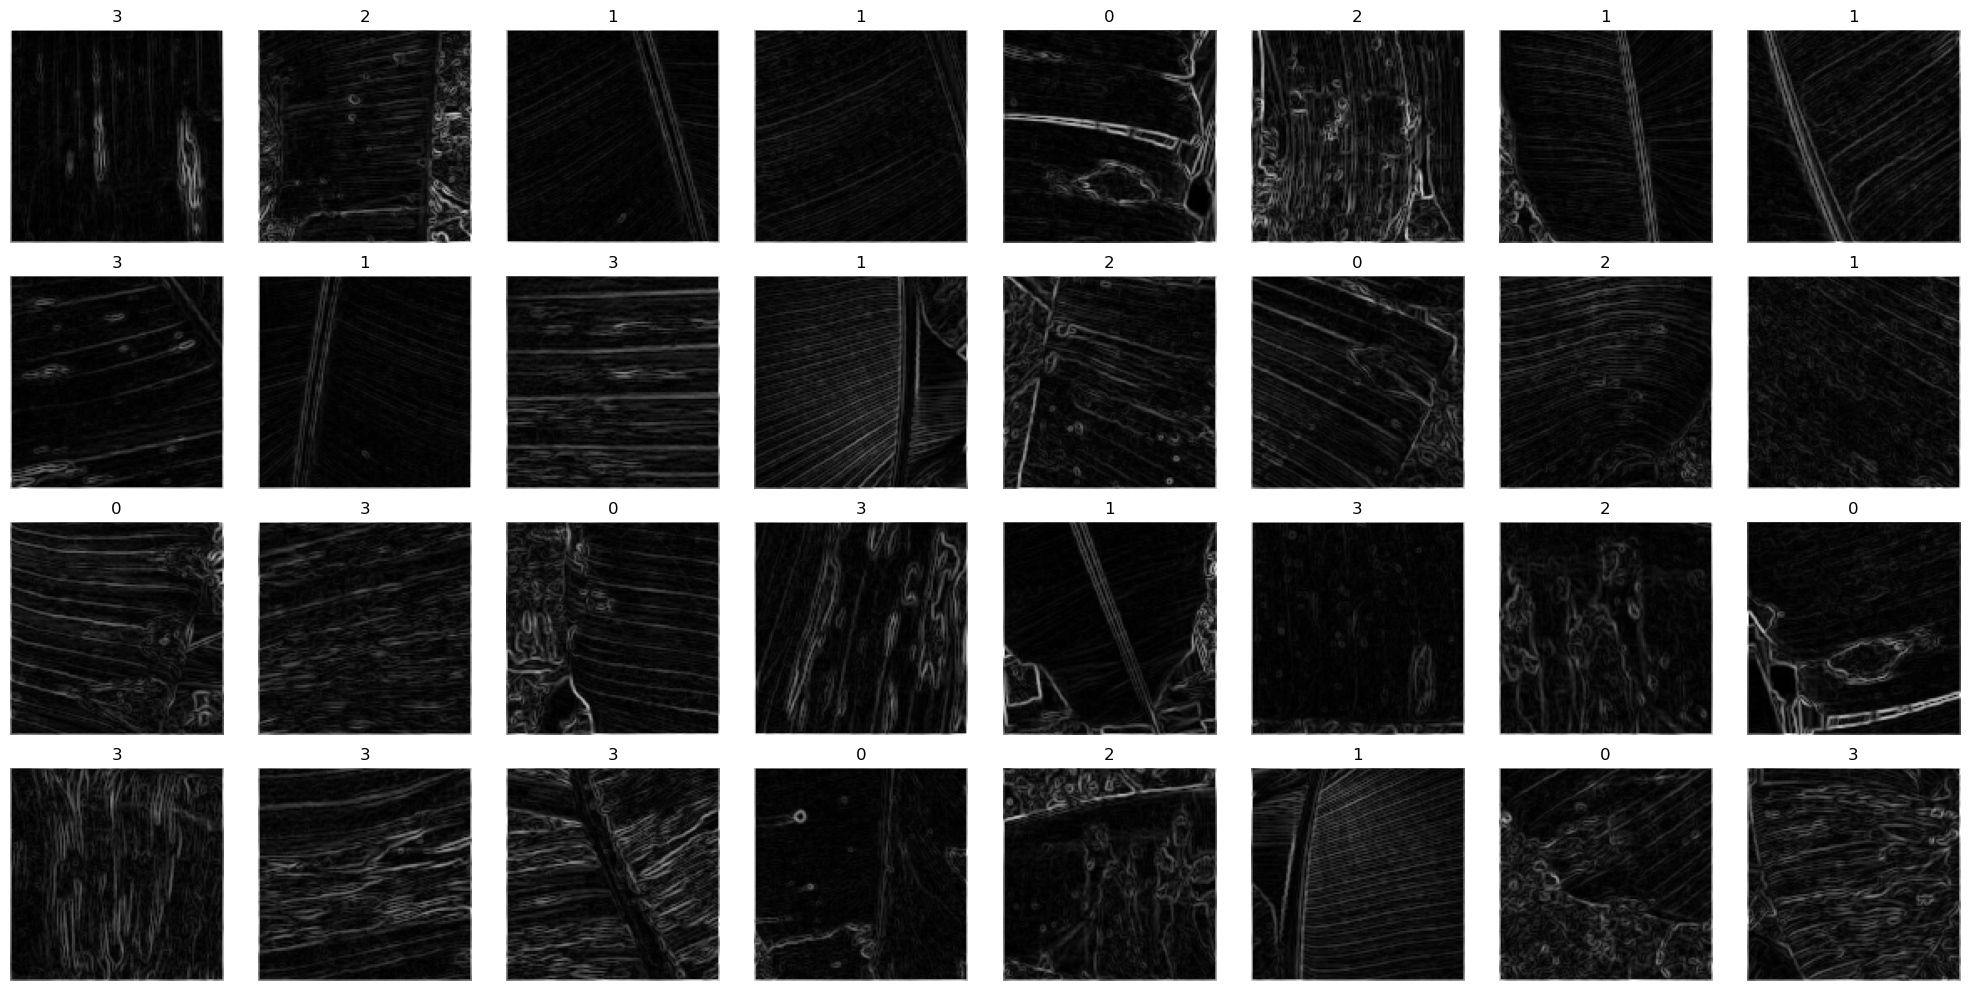

In [15]:
def plot_sobel_images(original_images, sobel_images, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for orig_img, sob_img, lbl, ax in zip(original_images, sobel_images, labels_arr, axes):
        ax.imshow(sob_img, cmap='gray')
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_sobel_images(images, sobel_images, labels)

In [18]:
type(train_generator)

keras.src.legacy.preprocessing.image.DirectoryIterator

EFFICIENETB0

In [22]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the pretrained EfficientNetB0 model without the top (output) layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers (optional, for transfer learning)
base_model.trainable = False

# Add custom layers on top of the base model
model_efficientnet = Sequential([
    base_model,  # Base EfficientNetB0 model
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    BatchNormalization(),
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),
    Dense(4, activation='softmax')  # Final output layer for 4 classes
])

# Compile the model
model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-3),  # Use Adam optimizer
    loss='categorical_crossentropy',    # Use categorical cross-entropy loss
    metrics=['accuracy']                # Track accuracy during training
)

# Train the model
history_efficientnet = model_efficientnet.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.2579 - loss: 1.7897 - val_accuracy: 0.2500 - val_loss: 1.3917
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.2488 - loss: 1.7289 - val_accuracy: 0.2500 - val_loss: 1.3876
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.2666 - loss: 1.5484 - val_accuracy: 0.2313 - val_loss: 1.3868
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.2357 - loss: 1.4831 - val_accuracy: 0.2500 - val_loss: 1.3865
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.2621 - loss: 1.4677 - val_accuracy: 0.2500 - val_loss: 1.3865
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.2652 - loss: 1.4265 - val_accuracy: 0.2500 - val_loss: 1.3864
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.2367 - loss: 1.4288 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.2310 - loss: 1.4325 - val_accuracy: 0

In [23]:
base_model.trainable = True
model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


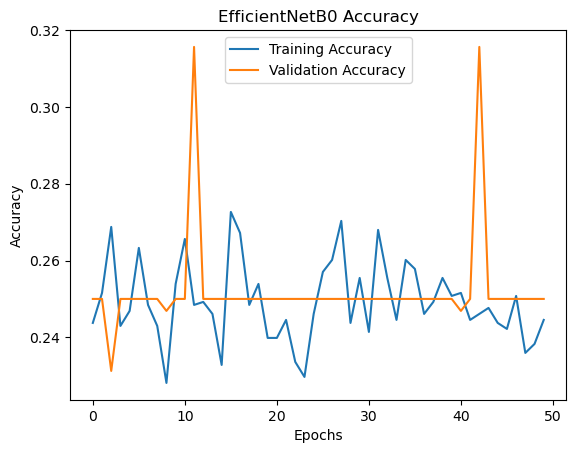

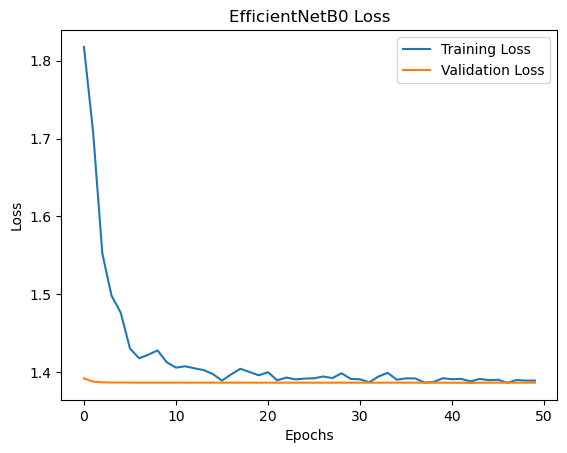

In [24]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_efficientnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_efficientnet.history['loss'], label='Training Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


MobileNetV3

In [26]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load the pretrained MobileNetV3Large model without the top (output) layer
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
model_mobilenetv3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Output for 4 classes
])

# Compile the model
model_mobilenetv3.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_mobilenetv3 = model_mobilenetv3.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.3992 - loss: 1.2821 - val_accuracy: 0.2625 - val_loss: 1.5218
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5825 - loss: 1.0497 - val_accuracy: 0.2562 - val_loss: 1.5743
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6412 - loss: 0.9402 - val_accuracy: 0.2562 - val_loss: 1.5338
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.6529 - loss: 0.8917 - val_accuracy: 0.2812 - val_loss: 1.5598
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.6976 - loss: 0.7915 - val_accuracy: 0.2812 - val_loss: 1.4282
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.6758 - loss: 0.7934 - val_accuracy: 0.3500 - val_loss: 1.4188
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.7052 - loss: 0.7603 - val_accuracy: 0.4469 - val_loss: 1.2702
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.7000 - loss: 0.7607 - val_accuracy: 0.

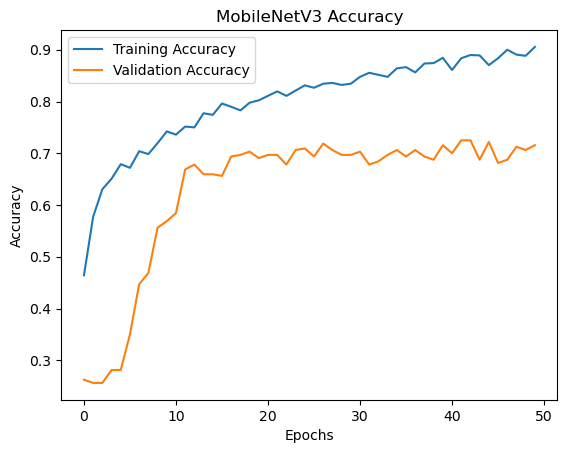

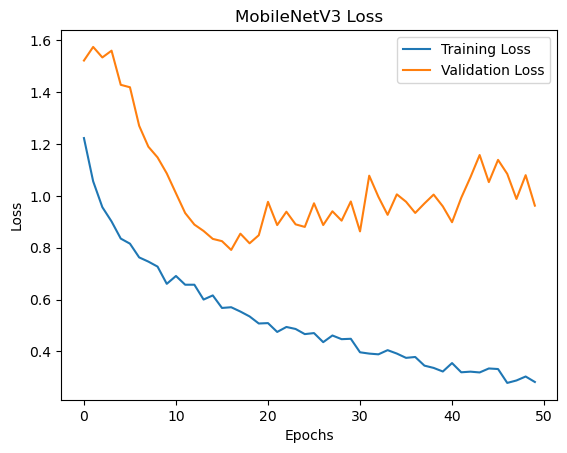

In [43]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_mobilenetv3.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenetv3.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_mobilenetv3.history['loss'], label='Training Loss')
plt.plot(history_mobilenetv3.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


ResNet101

In [29]:
from tensorflow.keras.applications import ResNet101

# Load the pretrained ResNet101 model without the top (output) layer
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
model_resnet101 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Output for 4 classes
])

# Compile the model
model_resnet101.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_resnet101 = model_resnet101.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 821ms/step - accuracy: 0.4370 - loss: 1.2667 - val_accuracy: 0.2500 - val_loss: 1.5511
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 751ms/step - accuracy: 0.5764 - loss: 1.0280 - val_accuracy: 0.2500 - val_loss: 1.5664
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 741ms/step - accuracy: 0.5947 - loss: 0.9635 - val_accuracy: 0.2500 - val_loss: 1.6316
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 713ms/step - accuracy: 0.6438 - loss: 0.9199 - val_accuracy: 0.2531 - val_loss: 1.5247
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 716ms/step - accuracy: 0.6643 - loss: 0.8455 - val_accuracy: 0.2500 - val_loss: 1.5046
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 714ms/step - accuracy: 0.6921 - loss: 0.8013 - val_accuracy: 0.2969 - val_loss: 1.3026
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 709ms/step - accuracy: 0.7255 - loss: 0.7524 - val_accuracy: 0.4219 - val_loss: 1.2028
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 711ms/step - accuracy: 0.7314 - loss: 0.7469 - val_accu

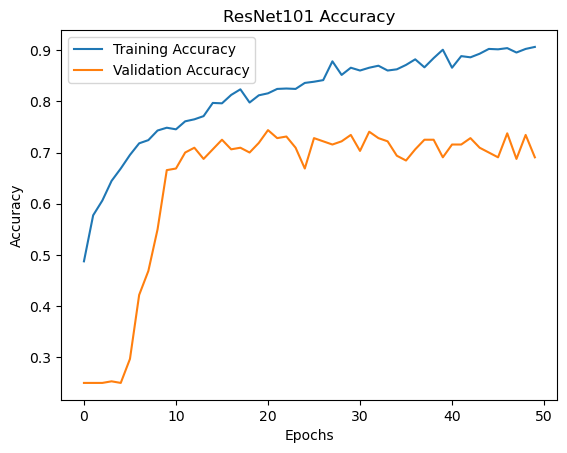

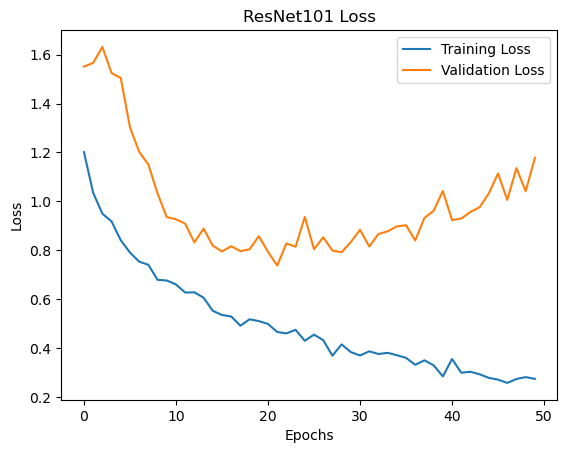

In [47]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_resnet101.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet101.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_resnet101.history['loss'], label='Training Loss')
plt.plot(history_resnet101.history['val_loss'], label='Validation Loss')
plt.title('ResNet101 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


ResNet50

In [39]:
from tensorflow.keras.applications import ResNet50

# Load the pretrained ResNet50 model without the top (output) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
model_resnet50 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Output for 4 classes
])

# Compile the model
model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - accuracy: 0.4236 - loss: 1.2606 - val_accuracy: 0.2500 - val_loss: 2.2470
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 382ms/step - accuracy: 0.5566 - loss: 1.0708 - val_accuracy: 0.3187 - val_loss: 2.0616
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 393ms/step - accuracy: 0.6442 - loss: 0.8813 - val_accuracy: 0.2531 - val_loss: 2.1024
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 407ms/step - accuracy: 0.6435 - loss: 0.8688 - val_accuracy: 0.2625 - val_loss: 2.0185
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step - accuracy: 0.7121 - loss: 0.7558 - val_accuracy: 0.2594 - val_loss: 1.9943
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step - accuracy: 0.7229 - loss: 0.7113 - val_accuracy: 0.3281 - val_loss: 1.7541
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 404ms/step - accuracy: 0.7360 - loss: 0.6518 - val_accuracy: 0.3719 - val_loss: 1.6550
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 410ms/step - accuracy: 0.7889 - loss: 0.5837 - val_accu

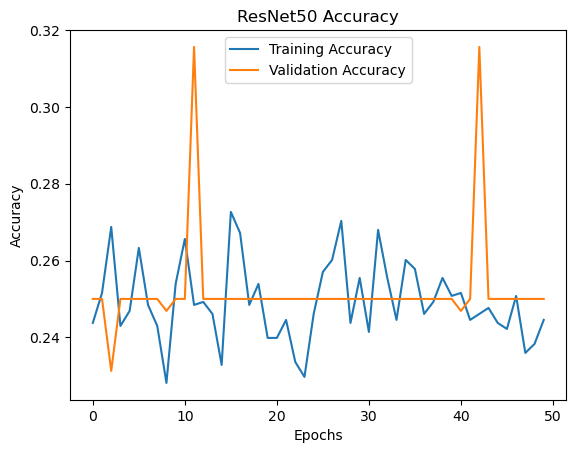

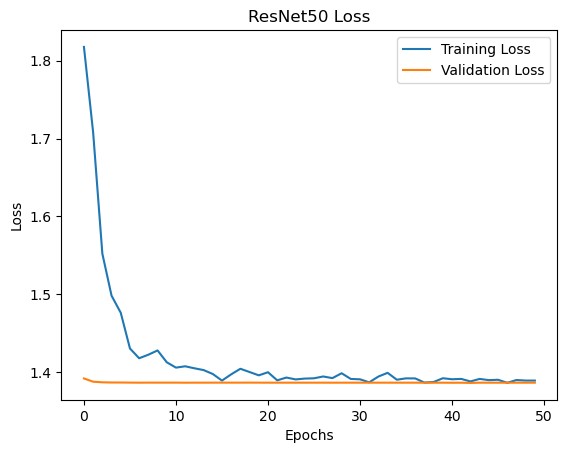

In [41]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


SqueezeNet

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam

def fire_module(x, squeeze_filters, expand_filters):
    """
    Implements a Fire module for SqueezeNet.
    
    Args:
        x: Input tensor.
        squeeze_filters: Number of filters in the squeeze layer.
        expand_filters: Number of filters in the expand layer.
        
    Returns:
        Output tensor of the Fire module.
    """
    # Squeeze layer
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same')(x)
    
    # Expand layer (1x1 and 3x3 convolutions)
    expand1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='same')(squeeze)
    expand3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)
    
    # Concatenate expand layers
    output = concatenate([expand1x1, expand3x3])
    return output

def build_squeezenet(input_shape=(128, 128, 3), num_classes=4):
    """
    Builds the SqueezeNet model.
    
    Args:
        input_shape: Shape of the input images (H, W, C).
        num_classes: Number of output classes.
        
    Returns:
        A Keras Model instance.
    """
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Fire modules
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    
    # Final layers
    x = Dropout(0.5)(x)
    x = Conv2D(num_classes, (1, 1), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    # Create model
    model = Model(inputs, outputs, name="SqueezeNet")
    return model

# Build and compile the model
model_squeezenet = build_squeezenet(input_shape=(128, 128, 3), num_classes=4)
model_squeezenet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_squeezenet = model_squeezenet.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)
